# Working with data

(from IDAO)  
300 ATMs with information about daily withdrawals (from 01/01/2015 to 15/08/2017)

## Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Reading the data

In [12]:
train = pd.read_csv('train.csv.zip', parse_dates=['DATE'])
train.tail()

,DATE,ATM_ID,CLIENT_OUT
287395,2017-08-11,419,47500
287396,2017-08-12,419,18100
287397,2017-08-13,419,5000
287398,2017-08-14,419,32300
287399,2017-08-15,419,78100


## Looking at the data

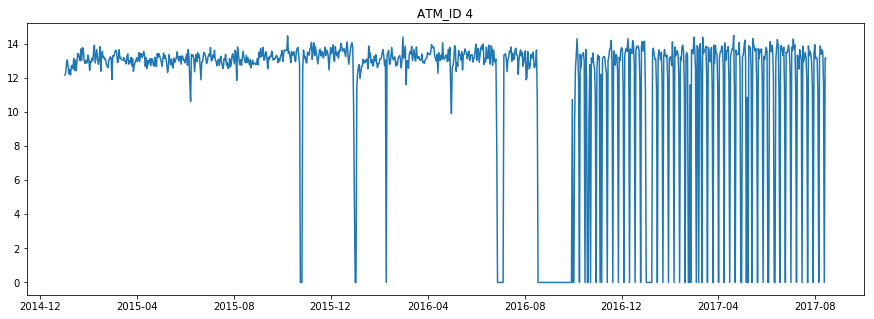

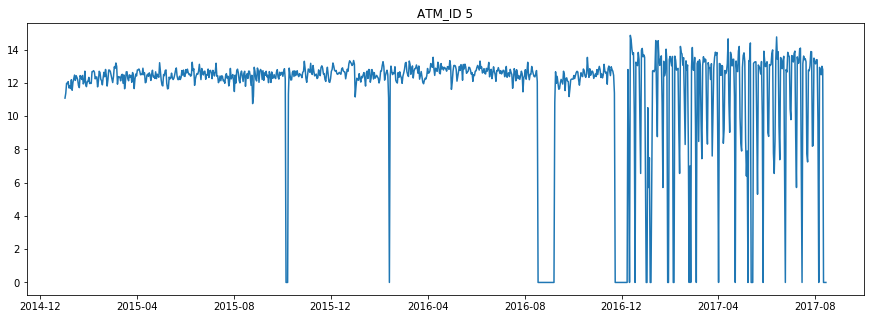

In [16]:
ids = train.ATM_ID.unique()
df = train
for id in ids[3:5]:
    plt.figure(figsize=(15,5))
    plt.title('ATM_ID {0}'.format(id))
    plt.plot(df[df.ATM_ID == id].DATE, np.log(1 + df[df.ATM_ID==id].CLIENT_OUT))
    plt.show()

## Generating features

In [31]:
def GenerateFeatures(df_init):
    """
    Takes: dataframe with the following columns: 'DATE', 'ATM_ID', 'CLIENT_OUT'.
    Returns: 5 dataframes with multiple features to predict for the following 5 weeks. (starting from the date of the row).
    Each dataframe uses the closest available two months of the known data. 
    
    Initial dataframe is not changed. 
    """
    df = df_init.copy()
    
    def holiday(df):
        condition_holiday = (
            (df.DATE.dt.month == 1) & ((df.DATE.dt.day >= 1) & (df.DATE.dt.day <= 8)) # winter
            | (df.DATE.dt.month == 2) & ((df.DATE.dt.day >= 21) & (df.DATE.dt.day <= 25)) # around 23 feb
            | (df.DATE.dt.month == 3) & ((df.DATE.dt.day >= 6) & (df.DATE.dt.day <= 10)) # around 8 mar
            | (df.DATE.dt.month == 5) & ((df.DATE.dt.day >= 1) & (df.DATE.dt.day <= 10)) # may
            | (df.DATE.dt.month == 6) & ((df.DATE.dt.day >= 10) & (df.DATE.dt.day <= 14)) # around 12 june
            | (df.DATE.dt.month == 11) & ((df.DATE.dt.day >= 2) & (df.DATE.dt.day <= 6)) # around 4 nov
        )
        
        return condition_holiday.astype(int)
    
    def shift(df2, number_of_week_for_prediction):
        df = df2.copy()
        
        for n in [1,2,3,4,5]:
            N = n + number_of_week_for_prediction - 1 # number of weeks look back
            df['same_day_{}_week_ago'.format(N)] = df.groupby(['ATM_ID'])['CLIENT_OUT'].shift(7*N).astype(np.float)
            df['mean_{}_week_ago'.format(N)] = df.groupby(['ATM_ID'])['mean'].shift(7*N).astype(np.float)
            df['std_{}_week_ago'.format(N)] = df.groupby(['ATM_ID'])['std'].shift(7*N).astype(np.float)
            
            # data 6 days ago is not available. The least lag is 7 days.
            if n != 1:
                df['same_day_{}_week_ago_plusday'.format(N)] = \
                    df.groupby(['ATM_ID'])['CLIENT_OUT'].shift(7*N-1).astype(np.float)
                
            df['same_day_{}_week_ago_minusday'.format(N)] = \
                df.groupby(['ATM_ID'])['CLIENT_OUT'].shift(7*N+1).astype(np.float)
        
        return df
    
    
    df['month_of_year'] = df.DATE.dt.month
    df['day_of_week'] = df.DATE.dt.dayofweek
    df['day_of_month'] = df.DATE.dt.day
    df['week_of_month'] = ((df.DATE.dt.day  - 1) // 7 + 1)
    
    df['weekend_dummy'] = (df.DATE.dt.dayofweek.isin([5,6])).astype(int)
    df['holiday_dummy'] = holiday(df)
    
    list_dummies = ['day_of_week', 
                    'day_of_month',
                    'week_of_month',
                    'month_of_year']
    
    df = pd.get_dummies(df, columns=list_dummies)
    
    df['mean'] = df.CLIENT_OUT.rolling(window=7, center=False).mean()
    df['std'] = df.CLIENT_OUT.rolling(window=7, center=False).std()
    
    list_of_df = []
    
    for i in range(1, 6):
        list_of_df.append(shift(df, i))
    
    for i in range(len(list_of_df)):
        list_of_df[i] = list_of_df[i].drop('mean', 1)
        list_of_df[i] = list_of_df[i].drop('std', 1)
        list_of_df[i] = list_of_df[i].dropna(subset=list_of_df[i].columns.drop('CLIENT_OUT'))
    
    return list_of_df

In [32]:
train.head()

,DATE,ATM_ID,CLIENT_OUT
0,2015-01-01,0,91600
1,2015-01-02,0,136500
2,2015-01-03,0,335400
3,2015-01-04,0,379000
4,2015-01-05,0,344100


In [29]:
df1, df2, df3, df4, df5 = GenerateFeatures(train)

In [33]:
df1.head()

,DATE,ATM_ID,CLIENT_OUT,weekend_dummy,holiday_dummy,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,same_day_4_week_ago,mean_4_week_ago,std_4_week_ago,same_day_4_week_ago_plusday,same_day_4_week_ago_minusday,same_day_5_week_ago,mean_5_week_ago,std_5_week_ago,same_day_5_week_ago_plusday,same_day_5_week_ago_minusday
41,2015-02-11,0,701700,0,0,0,0,1,0,0,...,537700.0,569485.714286,293299.365999,657300.0,1012100.0,158200.0,288585.714286,170580.923402,296500.0,575300.0
42,2015-02-12,0,492800,0,0,0,0,0,1,0,...,657300.0,621028.571429,267936.744489,417000.0,537700.0,296500.0,317857.142857,147110.308467,453400.0,158200.0
43,2015-02-13,0,598000,0,0,0,0,0,0,1,...,417000.0,615828.571429,272053.804202,177400.0,657300.0,453400.0,363128.571429,129732.798658,415900.0,296500.0
44,2015-02-14,0,267500,1,0,0,0,0,0,0,...,177400.0,581757.142857,313103.225029,189500.0,417000.0,415900.0,374628.571429,130431.204271,320000.0,453400.0
45,2015-02-15,0,323400,1,0,0,0,0,0,0,...,189500.0,563114.285714,334444.252597,326000.0,177400.0,320000.0,366200.000000,131998.535345,950800.0,415900.0


### Sanity check

In [35]:
'same_day_1_week_ago' in df1.columns

True

In [36]:
'same_day_1_week_ago' in df2.columns

False